In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import os
import time
import datetime


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import config

In [2]:
if config.ADSMI:
    from DL_finetune import ADSMI_DL_TVsplit as DL
    data_name = 'ADSMI'

In [3]:
#empty cuda cache
torch.cuda.empty_cache()

## Models


In [4]:
print(config.channels)

class Resnet50_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Resnet50_Classifier, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)
    



class ResNet101_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet101_Classifier, self).__init__()
        self.resnet101 = models.resnet101(pretrained=True)
        
        # Modify the first convolutional layer
        self.resnet101.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the final fully connected layer
        self.resnet101.fc = nn.Identity()  # Set the final layer to an identity mapping
        
        # Define the custom fully connected layers
        num_features = 2048 
        self.fc1 = nn.Linear(num_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.resnet101(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

    
class ModifiedResnet50_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResnet50_Classifier, self).__init__()
        
        # Load the pretrained ResNet-50 model
        #self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50 = models.resnet50()
        # Modify the first convolutional layer
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the final fully connected layer
        self.resnet50.fc = nn.Identity()  # Set the final layer to an identity mapping
        
        # Define the custom fully connected layers
        num_features = 2048 
        self.fc1 = nn.Linear(num_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.resnet50(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

3


In [5]:
#------Datasplit
# Load the dataframe
labels_file = pd.read_csv('./data/labeled_ADSMI/labels_int.csv', index_col=0)
#train_df, test_df = train_test_split(labels_file, test_size=0.2, stratify=labels_file['Label_int'], random_state=47)
#val_df = test_df
train_df, temp = train_test_split(labels_file, test_size=0.2, stratify=labels_file['Label_int'], random_state=47)
test_df, val_df = train_test_split(temp, test_size=0.5, stratify=temp['Label_int'], random_state=47)
# train test split
print("Train size: ", len(train_df))
print("Test size: ", len(test_df))
print("Val size: ", len(val_df))



print(train_df["Label_int"].value_counts())
print(test_df["Label_int"].value_counts())
print(val_df["Label_int"].value_counts())

train_loader, test_loader = DL.create_generators_finetune_train(train_df,test_df)




Train size:  3776
Test size:  472
Val size:  472
Label_int
0    1760
2    1332
1     570
3     114
Name: count, dtype: int64
Label_int
0    220
2    166
1     72
3     14
Name: count, dtype: int64
Label_int
0    220
2    167
1     71
3     14
Name: count, dtype: int64


In [6]:

#  Create an instance of the model
num_classes = len(set(labels_file["Label_int"]))  
#model = Resnet50_Classifier(num_classes)
model = ModifiedResnet50_Classifier(num_classes)
#model = ResNet101_Classifier(num_classes)

# Hyperparameters
num_epochs = num_epochs = config.finetune_epochs 
learning_rate = 0.0001
weight_decay = 1e-5  # L2 regularization
batch_size = config.batch_size
patience = config.patience

#  Transfer the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay ) # Adjust the value as needed)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.6, verbose=True)

#new folder path
standalone_results_path = f'./results_standalone/SA_ADSMI_{num_epochs}_epochs_{datetime.datetime.now().strftime("%Y-%m-%d-%H")}'

# Create a directory to save the results
if not os.path.exists(standalone_results_path):
    os.makedirs(standalone_results_path)

with open(f'{standalone_results_path}/log_file.txt', 'w') as log_file:
    log_file.write(f'########################################################\n')
    log_file.write(f'training on {data_name} dataset\n')
    log_file.write(f'Learning rate: {learning_rate}\n')
    log_file.write(f'Weight decay: {weight_decay}\n')
    log_file.write(f'Batch size: {batch_size}\n')
    log_file.write(f'Number of epochs: {num_epochs}\n')
    log_file.write(f'Patience: {patience}\n')
    log_file.write(f'Number of classes: {num_classes}\n')
    log_file.write(f'Train size: {len(train_df)}\n')
    log_file.write(f'Test size: {len(test_df)}\n')
    log_file.write(f'Val size: {len(val_df)}\n')
    log_file.write(f'freq_mask_param : {config.freq_mask_param}\n')
    log_file.write(f'time_mask_param : {config.time_mask_param}\n')
    log_file.write(f'########################################################\n\n')

train_losses = []
test_losses = []
early_stop_counter = 0
best_accuracy = 0
#config.model_path = "./results_standalone/newgpu2_checkpoint.pth"


In [7]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (spectrograms, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        train_losses.append(loss.item())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



    correct_predictions = 0
    total_samples = 0

    # Set the model to evaluation mode (important for dropout and batch normalization)
    model.eval()

    # Iterate through the test set
    with torch.no_grad():  # Disable gradient computation during testing
        for spectrograms, labels in test_loader:
            # Move data to the testing device
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())
            
            # Compute the predicted labels
            _, predicted = torch.max(outputs, 1)

            # Update evaluation metrics
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    #if new test accuracy is better than the previous best, save the model
    if correct_predictions / total_samples > best_accuracy:
        best_accuracy = correct_predictions / total_samples
        torch.save(model, standalone_results_path + '/checkpoint.pth')
        early_stop_counter = 0
        with open(f'{standalone_results_path}/log_file.txt', 'a') as log_file:
            log_file.write(f"Best accuracy improved on epoch {epoch}: {best_accuracy * 100:.2f}%\n")
        
    # Step the learning rate scheduler
    scheduler.step(test_losses[-1])

    # Calculate accuracy or other evaluation metrics
    accuracy = correct_predictions / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f} and Test Loss: {test_losses[-1]:.4f}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    early_stop_counter += 1

    with open(f'{standalone_results_path}/log_file.txt', 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f} and Test Loss: {test_losses[-1]:.4f}, Accuracy:{accuracy}, early stopping count: {early_stop_counter} from {patience}\n")

    #early stopping
    if early_stop_counter >= patience:
        print(f"Early stopping on epoch {epoch+1}")
        with open(f'{standalone_results_path}/log_file.txt', 'a') as log_file:
            log_file.write(f"Early stopping on epoch {epoch+1}\n")
        break
    




100%|██████████| 118/118 [00:38<00:00,  3.06it/s]


Epoch [1/120], Train Loss: 0.8417 and Test Loss: 0.6149
Test Accuracy: 69.07%


100%|██████████| 118/118 [00:28<00:00,  4.11it/s]


Epoch [2/120], Train Loss: 0.4165 and Test Loss: 0.4416
Test Accuracy: 70.34%


100%|██████████| 118/118 [00:28<00:00,  4.15it/s]


Epoch [3/120], Train Loss: 0.5848 and Test Loss: 0.5126
Test Accuracy: 79.45%


100%|██████████| 118/118 [00:28<00:00,  4.16it/s]


Epoch [4/120], Train Loss: 0.4274 and Test Loss: 0.3698
Test Accuracy: 82.63%


100%|██████████| 118/118 [00:28<00:00,  4.18it/s]


Epoch [5/120], Train Loss: 0.3744 and Test Loss: 0.3623
Test Accuracy: 86.23%


100%|██████████| 118/118 [00:28<00:00,  4.15it/s]


Epoch [6/120], Train Loss: 0.4334 and Test Loss: 0.2032
Test Accuracy: 88.56%


100%|██████████| 118/118 [00:28<00:00,  4.11it/s]


Epoch [7/120], Train Loss: 0.4518 and Test Loss: 0.5297
Test Accuracy: 86.65%


100%|██████████| 118/118 [00:29<00:00,  4.05it/s]


Epoch [8/120], Train Loss: 0.7910 and Test Loss: 0.3079
Test Accuracy: 88.35%


100%|██████████| 118/118 [00:28<00:00,  4.17it/s]


Epoch [9/120], Train Loss: 0.3734 and Test Loss: 0.2287
Test Accuracy: 88.98%


100%|██████████| 118/118 [00:28<00:00,  4.11it/s]


Epoch [10/120], Train Loss: 0.3503 and Test Loss: 0.3903
Test Accuracy: 87.71%


100%|██████████| 118/118 [00:28<00:00,  4.15it/s]


Epoch [11/120], Train Loss: 0.1444 and Test Loss: 0.2825
Test Accuracy: 89.62%


100%|██████████| 118/118 [00:28<00:00,  4.12it/s]


Epoch [12/120], Train Loss: 0.2940 and Test Loss: 0.4457
Test Accuracy: 87.50%


 25%|██▌       | 30/118 [00:07<00:21,  4.09it/s]


KeyboardInterrupt: 

In [8]:
# Save full model
torch.save(model, standalone_results_path + '/Full_model_checkpoint.pth')


Evaluation Results:
Balanced Accuracy2: 91.42%
Test Accuracy: 92.37%

Evaluation Results:
Accuracy: 92.37%
Precision: 92.84%
Recall: 92.37%
F1-score: 92.47%
Kappa: 88.12%
                         precision    recall  f1-score   support

            [Kreischen]       0.94      0.91      0.93       220
[Kreischen][Quietschen]       0.80      0.96      0.87        71
              [Negativ]       0.97      0.93      0.95       167
           [Quietschen]       0.86      0.86      0.86        14

               accuracy                           0.92       472
              macro avg       0.89      0.91      0.90       472
           weighted avg       0.93      0.92      0.92       472



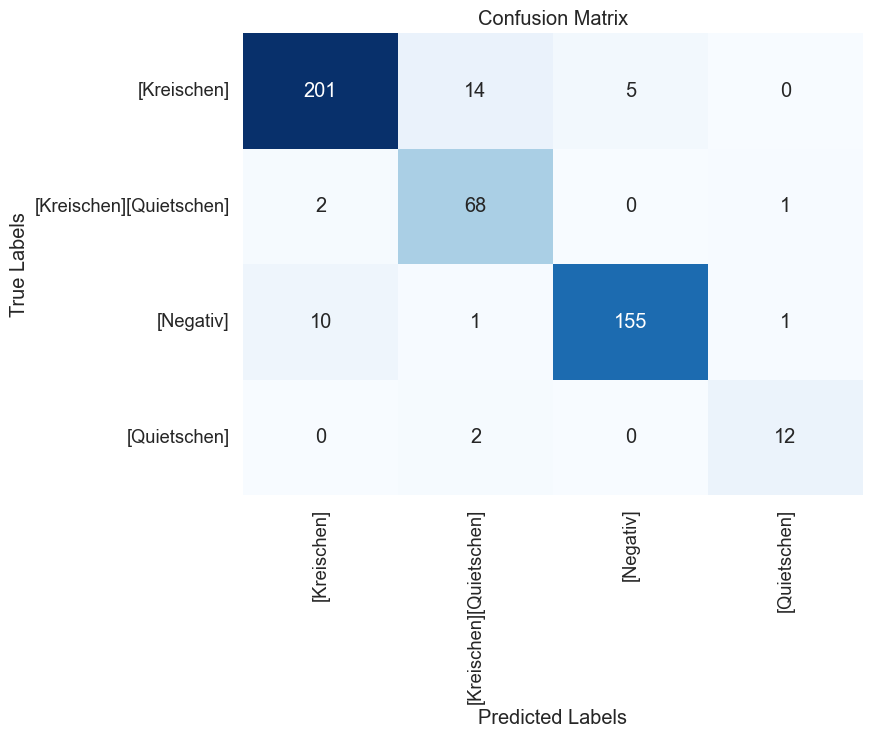

In [9]:

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score

# and loaded any pre-trained weights, e.g., model = Resnet50_Classifier(num_classes)

# Set the device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.val_sound_length = 20
# Create a data loader for the test set
val_loader = DL.create_generators_finetune_val(val_df)  

#model = torch.load("./results_standalone/newgpu2_checkpoint.pth")
model = torch.load(standalone_results_path + '/Full_model_checkpoint.pth')
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation (e.g., cross-entropy loss for classification)
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode 
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in val_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


#calculate balanced accuracy
balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
#print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)

    return plt.gcf()  # Return the current figure

import config
#create classification results text file
with open(f'{standalone_results_path}/results_file_full.txt', 'w') as log_file:
    log_file.write(f"########################################################\n")
    log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
    log_file.write(f"Time Mask: {config.time_mask_param}\n")
    log_file.write(f"Spectro:\n")
    log_file.write(f"        n_fft={2048},\n")
    log_file.write(f"        hop_length = {512},\n")
    log_file.write(f"        n_mels={128},  \n")
    log_file.write(f"        win_length = {2048},\n")
    log_file.write(f"Epochs: {num_epochs}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Optimizer: Adam\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Weight decay: {weight_decay}\n")
    log_file.write(f"Scheduler: ReduceLROnPlateau\n")
    log_file.write(f"Model: ModifiedResnet50_Classifier \n")
    log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
    log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"\nEvaluation Results:\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
    log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Confusion Matrix:\n")
    log_file.write(f"{conf_mat}\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

#save this plot as a png file
plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
plot.savefig(f'{standalone_results_path}/confusion_matrix_full.png')










Evaluation Results:
Balanced Accuracy2: 81.27%
Test Accuracy: 88.56%

Evaluation Results:
Accuracy: 88.56%
Precision: 89.60%
Recall: 88.56%
F1-score: 88.30%
Kappa: 81.66%
                         precision    recall  f1-score   support

            [Kreischen]       0.84      0.98      0.90       220
[Kreischen][Quietschen]       0.88      0.93      0.90        71
              [Negativ]       0.98      0.77      0.86       167
           [Quietschen]       0.89      0.57      0.70        14

               accuracy                           0.89       472
              macro avg       0.90      0.81      0.84       472
           weighted avg       0.90      0.89      0.88       472



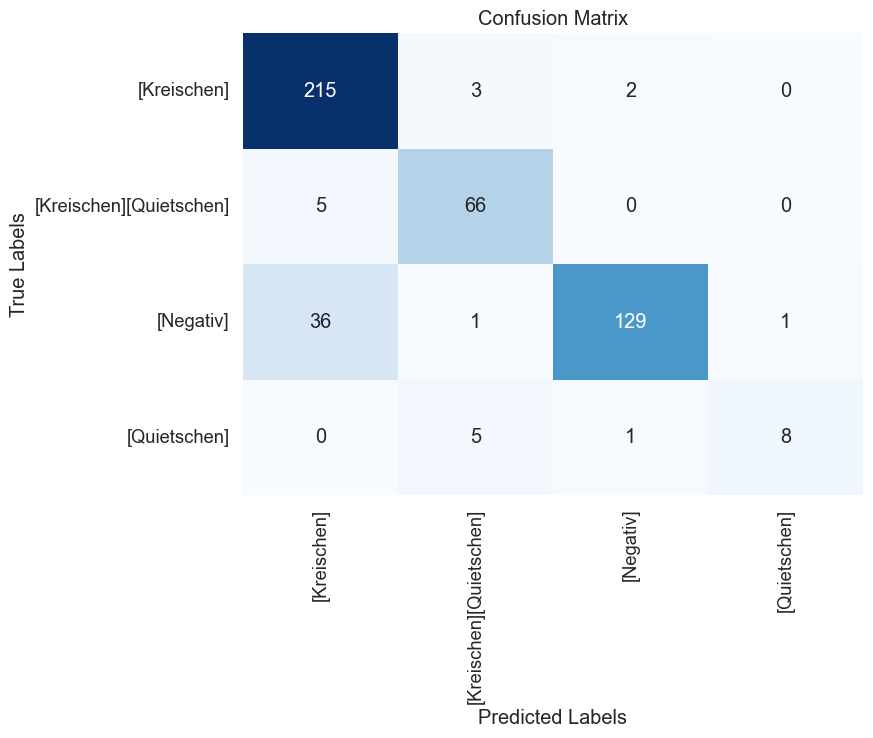

In [10]:

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score

# and loaded any pre-trained weights, e.g., model = Resnet50_Classifier(num_classes)

# Set the device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.val_sound_length = 20
# Create a data loader for the test set
val_loader = DL.create_generators_finetune_val(val_df)  

#model = torch.load("./results_standalone/newgpu2_checkpoint.pth")
model = torch.load(standalone_results_path + '/checkpoint.pth')
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation (e.g., cross-entropy loss for classification)
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode 
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in val_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
#use sklearn  accuracy 
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


#calculate balanced accuracy
balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
#print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)

    return plt.gcf()  # Return the current figure

import config
#create classification results text file
with open(f'{standalone_results_path}/results_file_best.txt', 'w') as log_file:
    log_file.write(f"########################################################\n")
    log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
    log_file.write(f"Time Mask: {config.time_mask_param}\n")
    log_file.write(f"Spectro:\n")
    log_file.write(f"        n_fft={2048},\n")
    log_file.write(f"        hop_length = {512},\n")
    log_file.write(f"        n_mels={128},  \n")
    log_file.write(f"        win_length = {2048},\n")
    log_file.write(f"Epochs: {num_epochs}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Optimizer: Adam\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Weight decay: {weight_decay}\n")
    log_file.write(f"Scheduler: ReduceLROnPlateau\n")
    log_file.write(f"Model: ModifiedResnet50_Classifier \n")
    log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
    log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"\nEvaluation Results:\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
    log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Confusion Matrix:\n")
    log_file.write(f"{conf_mat}\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

#save this plotas a png file
plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
plot.savefig(f'{standalone_results_path}/confusion_matrix_best.png')







